In [2]:
import os
from glob import glob
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
#from cmocean import cm
import numpy as np
from netCDF4 import Dataset
from scipy.io import loadmat

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
from dask.distributed import Client, LocalCluster
    #
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 128,Total memory: 251.08 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35299,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 128
Started: Just now,Total memory: 251.08 GiB
Comm: tcp://127.0.0.1:34947,Total threads: 8
Dashboard: http://127.0.0.1:44407/status,Memory: 15.69 GiB
Nanny: tcp://127.0.0.1:33787,


___________
# 1. Read Zach's data, and store as .nc files every one hour (9415 .nc files) 

In [4]:
# the path where (Zach's) LLC4320 data are already stored
LLC_data_folder = '/meddy/yuxlong5/data/LLC4320/'
# the path where the data will be re-stored
out_dir_nc = '/meddy/yuxlong5/data/data_store/'

# variable 
v = 'Theta'
# variable 
# v = 'Salt'

In [6]:
# search for right files, for example: Theta_177x201x52.*
filenames = sorted(glob(LLC_data_folder+v+'/'+v+'_177x201x52.*')) 
print('Number of files processed: %d' %len(filenames))

# store in netcdf files
fsize_bound = 5*1e6

for i in np.arange(len(filenames)):
#for i in np.arange(20):

    #
    file_out = out_dir_nc+'/%s_t%05d.nc'%(v, i)
          
    if not os.path.isfile(file_out) or os.path.getsize(file_out) < fsize_bound:            
        
        ds = np.fromfile(filenames[i] , dtype='>f').reshape(52,201,177)
        ds = np.array(ds)
        ds = xr.DataArray(ds, dims=['depth','lat','lon'])
        #ds = ds.assign_coords(time=time[i]) 
        ds = np.real(ds).rename(v)
        ds = ds.load() # this may be required in order to prevent pickle related errors

        #
        while True:
            try:
                ds.to_netcdf(file_out, mode='w', unlimited_dims=['time'])

            except:
                print('failure')
            break

    else:
        print('t=%d - allready processed'%(i))

Number of files processed: 9415


In [7]:
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime.datetime(2011,9,13)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

In [8]:
time=np.arange(len(filenames))*3600/86400
time

array([0.00000000e+00, 4.16666667e-02, 8.33333333e-02, ...,
       3.92166667e+02, 3.92208333e+02, 3.92250000e+02])

# 2. Add coordinates and put variables into one xarray file

In [9]:
filenames = sorted(glob(out_dir_nc+v+'_t*.nc')) 
print('Number of files processed: %d' %len(filenames))
%time ds = xr.open_mfdataset(filenames, concat_dim="time",combine="nested")
print(ds)

Number of files processed: 9415
CPU times: user 15.8 s, sys: 2.37 s, total: 18.2 s
Wall time: 53 s
<xarray.Dataset>
Dimensions:  (time: 9415, depth: 52, lat: 201, lon: 177)
Dimensions without coordinates: time, depth, lat, lon
Data variables:
    Theta    (time, depth, lat, lon) float32 dask.array<chunksize=(1, 52, 201, 177), meta=np.ndarray>


In [10]:
Depth = loadmat(LLC_data_folder+'grid/dpt52.mat')['dpt52']
Depth = np.array(Depth)
Depth = xr.DataArray(Depth, dims=['none','depth'])
Depth = xr.DataArray.squeeze(Depth, dim='none')
Depth = np.real(Depth).rename('Depth')

In [11]:
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime.datetime(2011,9,13)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

In [12]:
ds = ds.assign_coords(depth=Depth) 
ds = ds.assign_coords(time=np.arange(len(filenames))*3600/86400) 
print(ds)

<xarray.Dataset>
Dimensions:  (time: 9415, depth: 52, lat: 201, lon: 177)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
Dimensions without coordinates: lat, lon
Data variables:
    Theta    (time, depth, lat, lon) float32 dask.array<chunksize=(1, 52, 201, 177), meta=np.ndarray>


In [9]:
chunks = {'time': 9415, 'lat': 1, 'lon': 177, 'depth':1}
ds = ds.chunk(chunks)
print(ds)

Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.utils_perf.GCDiagnosis object at 0x2aabb7df3700>>
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/distributed/utils_perf.py", line 182, in _gc_callback
    def _gc_callback(self, phase, info):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [13]:
out_dir_zarr = '/meddy/yuxlong5/data/data_zarr/'

file_out = out_dir_zarr+'/%s_total_rechunk.zarr'%(v)
%time ds.to_zarr(file_out, mode='w')     

CPU times: user 24.9 s, sys: 3.6 s, total: 28.5 s
Wall time: 1min 25s


# Read re-chunked data

In [14]:
out_dir_zarr = '/meddy/yuxlong5/data/data_zarr/'

ds = xr.open_zarr(out_dir_zarr+v+'_total_rechunk.zarr')
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (time: 9415, depth: 52, lat: 201, lon: 177)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
Dimensions without coordinates: lat, lon
Data variables:
    Theta    (time, depth, lat, lon) float32 dask.array<chunksize=(1, 52, 201, 177), meta=np.ndarray>

 data size: 69.7 GB


CPU times: user 15.3 s, sys: 1.01 s, total: 16.3 s
Wall time: 16.9 s


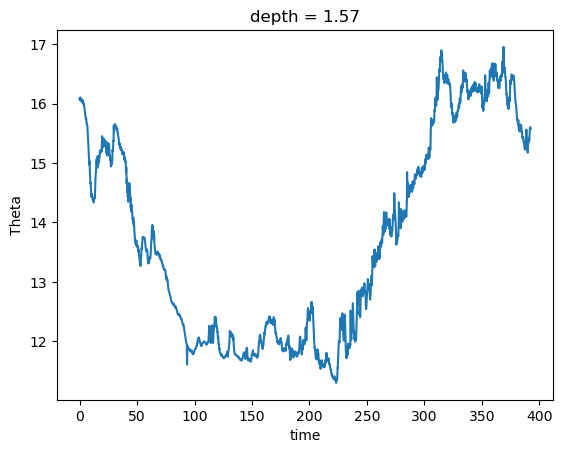

In [15]:
%time ds[v].isel(depth=1, lat=slice(90,100), lon=slice(90,100)).mean(dim=['lat','lon']).plot()

In [8]:
LLC_XC = np.fromfile(LLC_data_folder+"grid/XC_177x201", dtype='>f').reshape(201,177)
LLC_XC = np.array(LLC_XC)
LLC_XC = xr.DataArray(LLC_XC, dims=['lat','lon'])
LLC_XC = np.real(LLC_XC).rename('LLC_XC')

In [9]:
LLC_YC = np.fromfile(LLC_data_folder+"grid/YC_177x201", dtype='>f').reshape(201,177)

LLC_YC = np.array(LLC_YC)
LLC_YC = xr.DataArray(LLC_YC, dims=['lat','lon'])
LLC_YC = np.real(LLC_YC).rename('LLC_YC')

In [10]:
Depth = loadmat(LLC_data_folder+'grid/dpt52.mat')['dpt52']
Depth = np.array(Depth)
Depth = xr.DataArray(Depth, dims=['none','depth'])
Depth = xr.DataArray.squeeze(Depth, dim='none')
Depth = np.real(Depth).rename('Depth')

In [11]:
ds = ds.assign_coords(depth=Depth) 
lat = LLC_YC.isel(lon=1)
lon = LLC_XC.isel(lat=1)
ds = ds.assign_coords(lat=lat) 
ds = ds.assign_coords(lon=lon)
print(ds)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) >f4 47.404716 47.417923 47.43113 47.444332 47.45753 ...
  * lon      (lon) >f4 -18.03125 -18.010416 -17.989584 -17.96875 -17.947916 ...
Dimensions without coordinates: time
Data variables:
    Theta    (time, depth, lat, lon) float32 dask.array<shape=(9415, 52, 201, 177), chunksize=(1, 52, 201, 177)>


In [16]:
cluster.close()